# Тестирование планирования траектории с помощью полиномов пятого порядка

Полиномы 5-го порядка являются оптимальной траекторией из состояния $[x_1, \dot{x_1}, \ddot{x_1}]$ в состояние $[x_2, \dot{x_2}, \ddot{x_2}]$, минимизируя функционал стоимости:
$$
J = \int_{t_0}^{t_1}\dddot{x}^2(t)dt
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.lines as mlines

In [2]:
# Находит коэффициенты полинома 
# s1 - начальное состояние (x, dx/dt, d2x/dt^2) 
# s2 - конечное состояние  (x, dx/dt, d2x/dt^2)
# T  - время перехода
# Возвращает коэффициенты полинома
def quintic_solve(s1, s2, T):
    A = np.array([[   0,       0,       0,      0,    0, 1],
                  [   0,       0,       0,      0,    1, 0],
                  [   0,       0,       0,      1,    0, 0],
                  [   T**5,    T**4,    T**3,   T**2, T, 1],
                  [ 5*T**4,  4*T**3,  3*T**2, 2*T,    1, 0], 
                  [20*T**3, 12*T**2,  6*T,      1,    0, 0]])
    B = np.array([s1[0], s1[1], s1[2], s2[0], s2[1], s2[2]])
    return np.linalg.solve(A, B)

def calc_quintic(a, x):
    return a[0]*x**5 + a[1]*x**4 + a[2]*x**3 + a[3]*x**2 + a[4]*x + a[5]

def calc_dquintic(a, x):
    return 5*a[0]*x**4 + 4*a[1]*x**3 + 3*a[2]*x**2 + 2*a[3]*x + a[4]

def calc_ddquintic(a, x):
    return 20*a[0]*x**3 + 12*a[1]*x**2 + 6*a[2]*x + a[3]

def quintic_interpolate(a, linspace):
    x, dx, ddx = [], [], []
    
    for t in linspace:
        x.append(calc_quintic(a, t))
        dx.append(calc_dquintic(a, t))
        ddx.append(calc_ddquintic(a, t))
        
    return x, dx, ddx

In [3]:
class FrenetFrame:
    """
    Represents the Frenet Frame
    
    Perform transformation world frame -> local frenet frame
    and local frenet frame -> world frame
    
    Notation:        
        tr  - tangent vector
        nr  - normal vector
        br  - binormal vector (for surface - up)
        Rwf - orientation of local frame with respect to parent frame           
        Rfw - orientation of world frame with respect to parent frame
        Pwf - position of the origin of the local with respect to parent frame
        S0  - covered curve length at the origin of the current frame
    
    Math:
        local->parent transformation:
            Qw = Pwf + Rwf*Qf
            Qa - position in parent frame
            Qb - position in local frame
    
    """
    def __init__(self, s0, p1, p2):
        """
        Create Frenet Frame with two close points on discrete curve.
        Frenet Frame origin will be in point p1
        
        Args:
            s0     - Covered curve length at the point p1.
                     (sum of the length of the all previous segments)
            p1, p2 - Current and next points on the curve.
                     p1p2 is a tangent vector.             
        """
        # local frame axis in parent frame
        self.br = [0, 0, 1]
        self.tr = p2-p1
        self.tr = self.tr/np.linalg.norm(self.tr)
        self.nr = np.cross(self.br, self.tr)[:2]
        
        # local frame orientation with respect to parent frame
        self.Rwf = np.identity(2)
        self.Rwf[:,0]=self.tr
        self.Rwf[:,1]=self.nr
        #self.Rwf[:,2]=self.br
        
        # parent frame orientation with respect to local frame
        self.Rfw = np.transpose(self.Rwf)
        
        # position of the origin of the local with respect to parent frame
        self.Pwf = p1
        
        self.S0 = np.array([s0, 0])
        
    def point_to(self, point):
        """
        Transofrm point in parent frame to the local frame
        """
        return np.matmul(self.Rfw, point - self.Pwf) + self.S0
        
    def point_from(self, point):
        """
        Transofrm point in local frame to the parent frame
        """
        return np.matmul(self.Rwf, point - self.S0)+self.Pwf
    
    def vector_to(self, vector):
        """
        Transform the vector in parent frame to the local frame
        (Position of the frame origin has no effect)
        """
        return np.matmul(self.Rfw, vector)
    
    def vector_from(self, vector):
        """
        Transform the vector in local frame to the parent frame
        (Position of the frame origin has no effect)
        """
        return np.matmul(self.Rwf, vector)

In [20]:
# Создает тестовый путь
def create_path(a1, a2, scale, n):
    p = np.zeros((n, 2))
    i = 0
    for a in np.linspace(math.radians(a1), math.radians(a2), n):
        y = math.sin(a)*scale
        p[i] = [a,y]
        i+=1
        
    return p

def draw_frame(ax, frame):
    l1 = frame.Pwf
    l2 = frame.Pwf + frame.tr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='red')
    ax.add_line(line)
    l1 = frame.Pwf
    l2 = frame.Pwf + frame.nr*0.5
    line = mlines.Line2D([l1[0], l2[0]], [l1[1], l2[1]], color='green')
    ax.add_line(line)

def combine(variant):
    ts, lateral, longitudinal = variant
    n = len(ts)
    coords = np.zeros((n, 2))
    
    for i in range(n):
        x = longitudinal[i]
        y = lateral[i]
        coords[i] = [x,y]
        
    return coords

def path_to_global(local_path, curve):
    """
    Convert local path in Frenet Frame to the path in global frame
    
    Args:
        local_path - local path in Frenet Frame (numpy array)
        curve      - original (reference) trajectory. 
                     local path will be "bended" along curve
    """
    global_path = np.zeros((len(local_path), 2))
    i = 0
    curve_index = 0
    curve_s = 0
    curve_s_next = np.linalg.norm(curve[0] - curve[1])
    
    for point in local_path:
        s = point[0]
        
        while True:            
            if curve_s_next >= s:
                break
            
            if curve_index >= len(curve)-2:
                return global_path[:i]
                
            curve_s = curve_s_next
            curve_s_next += np.linalg.norm(curve[curve_index+1] - curve[curve_index])
            curve_index += 1
            
        p1 = curve[curve_index]
        p2 = curve[curve_index+1]                        
        
        frenet = FrenetFrame(curve_s, p1, p2)
        p = frenet.point_from(point)        
        global_path[i] = frenet.point_from(point)
        i+=1
        
    return global_path

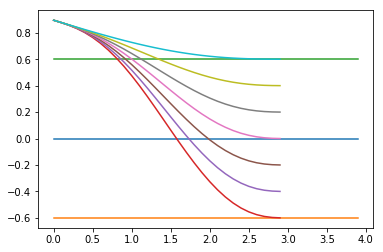

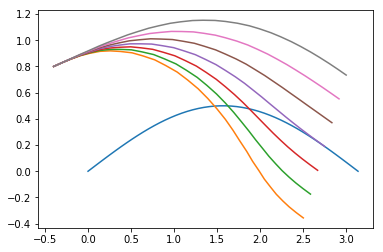

In [57]:
ROAD_WIDTH = 1.2

T_MIN = 4.0
T_MAX = 8.0
T_STEP = 1
T_CALC_STEP = 0.2

D_MIN = -ROAD_WIDTH/2
D_MAX = ROAD_WIDTH/2
D_STEP = 0.2

VELOCITY = 0.5
T_ALL = 15

path = create_path(0, 180, 0.5, 50)
car_p = np.array([0, 1])
car_v = np.array([1, 0.4])
frenet = FrenetFrame(0, path[0], path[1])
car_p_f = frenet.point_to(car_p)  # Car positon in Frenet Frame
car_v_f = frenet.vector_to(car_v) # Car velocity in Frenet Frame

quintics = []
frenet_paths = []
global_paths = []


# Create a set of lateral and longitudal quintic polynoms
for ti in [6.0]: #np.arange(T_MIN, T_MAX + T_STEP, T_STEP):
    ts = np.arange(0, ti, T_CALC_STEP) #??
    
    for di in np.arange(D_MIN, D_MAX + D_STEP, D_STEP):
        # Create lateral motion
        d1 = car_p_f[1]    # lateral position
        dd1 = car_v_f[1]   # lateral speed 
        lateral_coefs = quintic_solve([d1, dd1, 0], [di, 0, 0], ti)
        lat, _, _ = quintic_interpolate(lateral_coefs, ts)
        #plt.plot(ts, d)
            
        # Create longitude motion
        # For now assume constant velocity
        s1 = car_p_f[0]   # longitudinal position
        ds1 = car_v_f[0]  # longitudinal speed
        longitudinal_coefs = [0, 0, 0, 0, VELOCITY, 0]
        long, _, _ = quintic_interpolate(longitudinal_coefs, ts)
        
        quintics.append((ts, lat, long))

for variant in quintics:
    frenet_paths.append(combine(variant))
        
        
n = 40
fp_c = np.zeros((n, 2))
fp_min = np.zeros((n, 2))
fp_max = np.zeros((n, 2))
for i in range(n):
    fp_c[i]=[i*0.1, 0]
    fp_min[i]=[i*0.1, D_MIN]
    fp_max[i]=[i*0.1, D_MAX]
    
    

plt.plot(fp_c[:,0], fp_c[:,1])    
plt.plot(fp_min[:,0], fp_min[:,1])    
plt.plot(fp_max[:,0], fp_max[:,1])    

for fpath in frenet_paths:
    plt.plot(fpath[:,0], fpath[:,1])

plt.show()


plt.plot(path[:,0], path[:,1])
#plt.plot(gp_c[:,0], gp_c[:,1])
#plt.plot(gp_min[:,0], gp_min[:,1])
#plt.plot(gp_max[:,0], gp_max[:,1])


for fpath in frenet_paths:
    global_path = path_to_global(fpath, path)
    plt.plot(global_path[:,0], global_path[:,1])

plt.show()

    
plt.show()